In [44]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [5]:
#Set random seed for reproducibility
np.random.seed(42)

In [45]:
#Load my data

df=pd.read_csv('TASK-ML-INTERN.csv')
df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [7]:
#Drop the ID column because it’s not needed

df.drop(columns=["hsi_id"], inplace=True)


In [8]:
#Split into features and target

X = df.iloc[:, :-1]  # All columns except the last one (spectral bands)
y = df.iloc[:, -1]   # Last column (assumed to be DON_concentration)

In [9]:
#Scale features to 0-1

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [10]:
#Scale target for better results

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

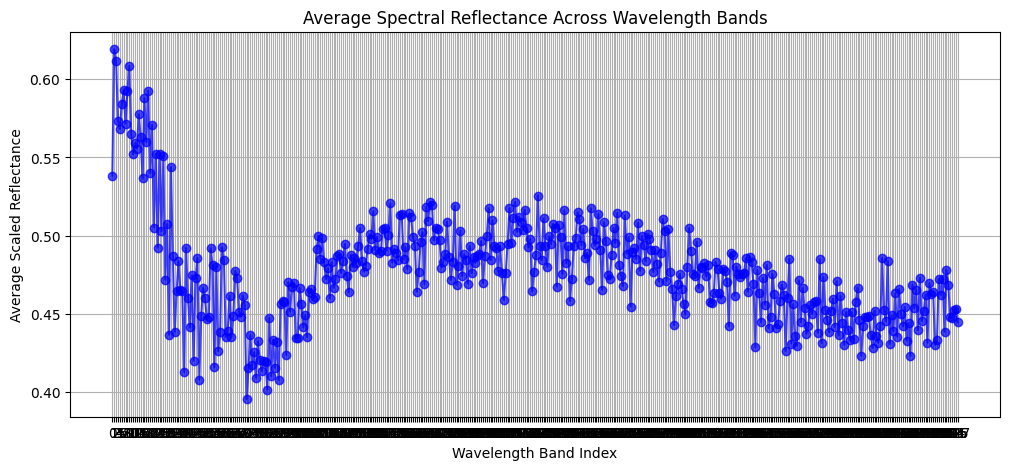

In [11]:
#Plot average reflectance to see the data

plt.figure(figsize=(12, 5))
plt.plot(X_scaled_df.mean(), marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Average Scaled Reflectance")
plt.title("Average Spectral Reflectance Across Wavelength Bands")
plt.grid()
plt.show()

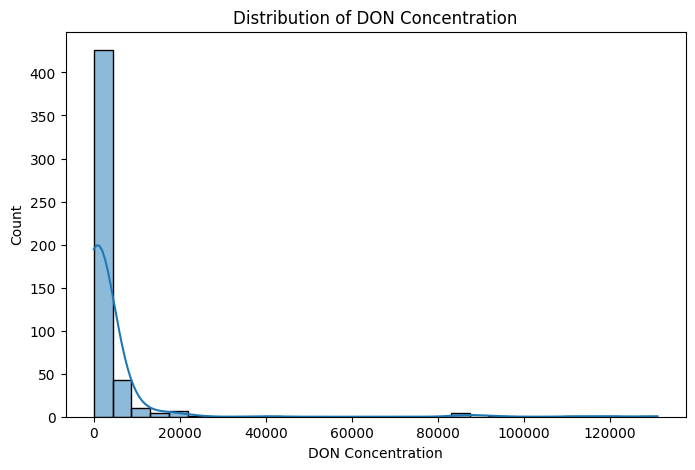

In [54]:
#DON distribution

plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True)
plt.xlabel("DON Concentration")
plt.title("Distribution of DON Concentration")
plt.show()


In [53]:
#PCA with 2 components

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [52]:
#Show PCA variance
print("Explained Variance Ratio for 2 Components:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))


Explained Variance Ratio for 2 Components: [0.8582386  0.06683037]
Total Explained Variance: 0.9250689700441113


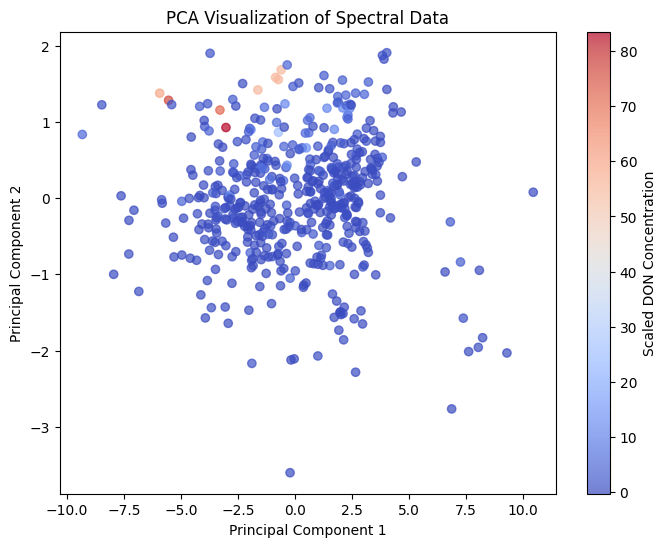

In [51]:
# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y_scaled, cmap="coolwarm", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Spectral Data")
plt.colorbar(scatter, label="Scaled DON Concentration")
plt.show()

In [50]:
#Components for 95% variance

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 4


In [55]:
# Picking top 150 features

from sklearn.feature_selection import SelectKBest, mutual_info_regression
selector = SelectKBest(score_func=mutual_info_regression, k=150)
X_selected = selector.fit_transform(X_scaled, y_scaled)

In [34]:
# Split data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_scaled, test_size=0.2, random_state=42)
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (400, 150)
Testing Set Shape: (100, 150)


In [35]:
#Train a simple XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [36]:
#Make predictions on the test set
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [37]:
#Calculate how good the model is
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

In [38]:
print("\nModel Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)



Model Performance:
MAE: 2098.5058602905274
RMSE: 5388.656266404981
R² Score: 0.8961210139084107


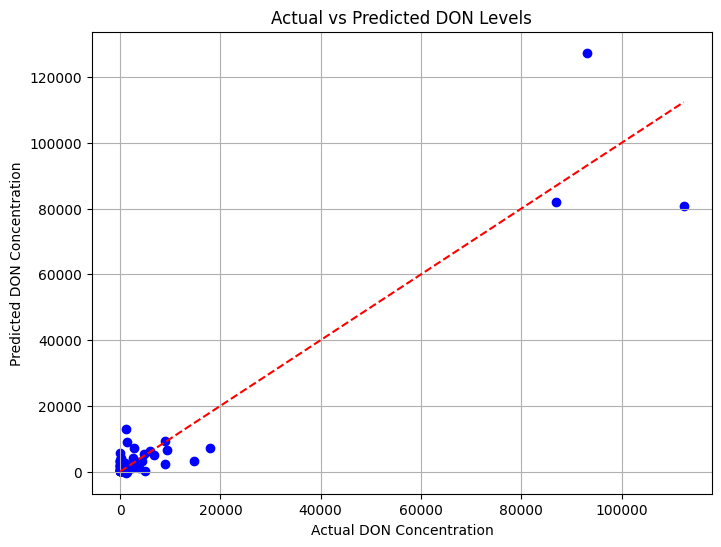

In [39]:
#Plot actual vs predicted

plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred, color='blue')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs Predicted DON Levels")
plt.grid()
plt.show()

In [40]:
#Showing Top Features
feature_importance = model.feature_importances_
selected_features = X.columns[selector.get_support()]
feature_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

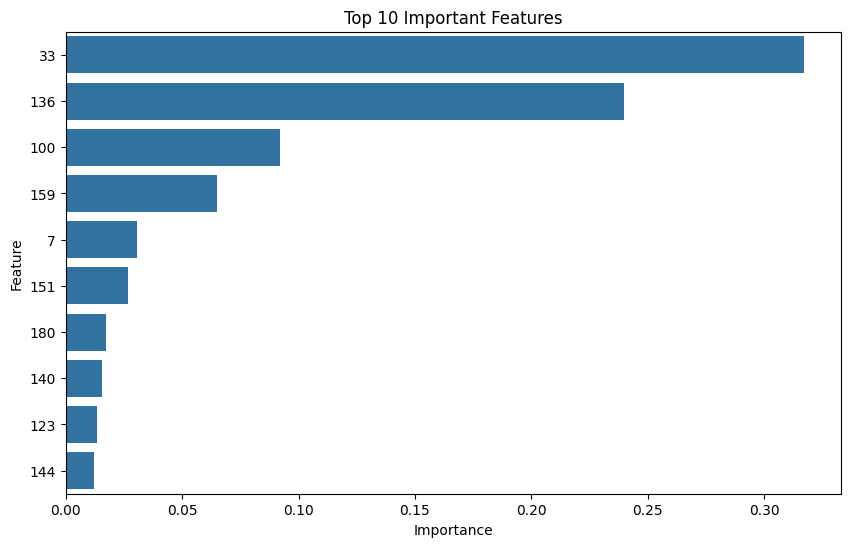

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10))
plt.title("Top 10 Important Features")
plt.show()